# Utilities


In [1]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 14.9 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=6837739c315f8f2d60d5c363d38ad8aa1a1d8ba973be271e74fc4c87d591f76d
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [2]:
import numpy as np
import cv2
from sklearn import preprocessing
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import swifter
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans


In [3]:
# Function to check if a point is within any boundary box
def is_within_boundary_box(coords, box):
    min_latitude, min_longitude, max_latitude, max_longitude = box
    if (min_longitude < coords[1] < max_longitude and min_latitude < coords[0] < max_latitude):
      return True
    return False


# Function to check if a point is within any boundary box
def is_within_boundary_boxes(coords, boundary_boxes):
    for box in boundary_boxes:
        min_latitude, min_longitude, max_latitude, max_longitude = box
        if is_within_boundary_box(coords, box):
            return True
    return False

# Function to filter DataFrame based on boundary boxes
def filter_by_boundary_boxes(df, boundary_boxes):
  try:
    filtered_df = df[df.swifter.apply(lambda row: is_within_boundary_boxes((row['Latitude'], row['Longitude']), boundary_boxes), axis=1)]
    return filtered_df
  except:
    filtered_df = df[df.swifter.apply(lambda row: is_within_boundary_box((row['Latitude'], row['Longitude']), boundary_boxes), axis=1)]
    return filtered_df






def select_grid(file, boundary_boxes):
  emag_ds = pd.read_csv('/content/EMAG2v3onPredictorMesh.csv')

  for file in os.listdir('/content/'):
    if file.endswith('.nc'):
      print(file)
      predictor_xarray = xr.open_dataset(f'/content/{file}')

      try:
        predictor_data = np.array(predictor_xarray['z']).flatten()
      except:
        print('error')
      predictor_ds = pd.DataFrame({file[13:]: predictor_data})
      emag_ds = emag_ds.join(predictor_ds)

  # Save the filtered DataFrame to a CSV file
  filtered_emag = filter_by_boundary_boxes(emag_ds, boundary_boxes)
  return filtered_emag

In [4]:
def plot_on_selections(filtered_emag, boundary_boxes, name = 'EMAG2v3'):
       for box in boundary_boxes:
          plotting_emag = filter_by_boundary_boxes(filtered_emag, box)
          plotting_emag = plotting_emag.reset_index(drop=True)

          grid_df = plotting_emag.pivot(index='Latitude', columns='Longitude', values = name)

          # Step 3: Convert the pivoted DataFrame to an xarray.DataArray
          data_array = xr.DataArray(grid_df.values,
                                    coords=[grid_df.index, grid_df.columns],
                                    dims=['Latitude', 'Longitude'])


          if name == 'EMAG2v3':
            data_array.plot(vmin = np.percentile(plotting_emag[name],10), vmax = np.percentile(plotting_emag[name],90), cmap='RdYlBu_r')
            plt.title(f'Grid Data')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.show()
          else:
            data_array.plot(vmin = np.percentile(plotting_emag[name],10), vmax = np.percentile(plotting_emag[name],90), cmap='RdYlBu_r')
            plt.title(f'Grid Data')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.show()

def evaluate_model(y_test, y_pred,X):
  # Calculate Mean Squared Error (MSE)
  mse = mean_squared_error(y_test, y_pred)
  print(f"Mean Squared Error: {mse}")  # Measures the average squared difference between predicted and actual values

  # Calculate R-squared (R²)
  r2 = r2_score(y_test, y_pred)
  print(f"R² Score: {r2}")  # Represents the proportion of the variance in the dependent variable that is predictable from the independent variables

  # Calculate Root Mean Squared Error (RMSE)
  rmse = np.sqrt(mse)
  print(f"Root Mean Squared Error: {rmse}")  # Provides an absolute measure of fit by taking the square root of MSE

  # Calculate Mean Absolute Error (MAE)
  mae = mean_absolute_error(y_test, y_pred)
  print(f"Mean Absolute Error: {mae}")  # Measures the average magnitude of the errors in a set of predictions, without considering their direction

  # Calculate the standard deviation of the target variable in the test set
  std_dev = np.std(y_test)

  # Calculate Coefficient of Variation of RMSE (CV(RMSE))
  cv_rmse = rmse / std_dev
  print(f"Coefficient of Variation of RMSE: {cv_rmse}")  # Normalizes RMSE by dividing it by the standard deviation of the target variable


  print(f'Included Predictors:\n{include_columns}')


def scatter_plot(y_test, y_pred):
  # Create a scatter plot
  plt.figure(figsize=(8, 8))
  plt.scatter(y_pred, y_test, alpha=0.5, color='b')
  # Plot a line for perfect predictions
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')

  # Add labels and title
  plt.xlabel('Predicted Values (y_pred)')
  plt.ylabel('Actual Values (y_test)')
  plt.title('Actual vs. Predicted Values: region_benchmark')

  # Show the plot
  plt.grid(True)
  plt.show()


# Benchmark Datasets
## Atlantic Region

Larger dataset to train and test via random selection.
## Atlantic Region Holes
Smaller dataset to test accuracy of the atlantic region trained model.
* Train and test a model on this dataset to see the difference in performance.






In [5]:
big_grid = pd.read_csv('/content/2nd_atlantic_region_hole_benchmark.csv')
holes_grid = pd.read_csv('/content/2nd_atlantic_region_holes.csv')


region = [(38, -25, 48, -15)]

holes = [
    (39,-23,40,-22),
    (42,-20, 43,-19),
    (43,-17,44,-16)
]




Pandas Apply:   0%|          | 0/321 [00:00<?, ?it/s]

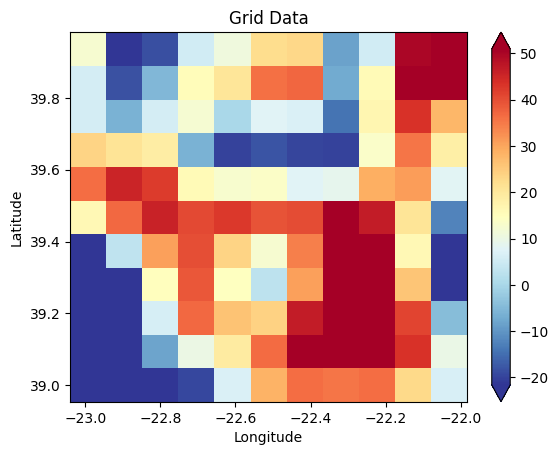

Pandas Apply:   0%|          | 0/321 [00:00<?, ?it/s]

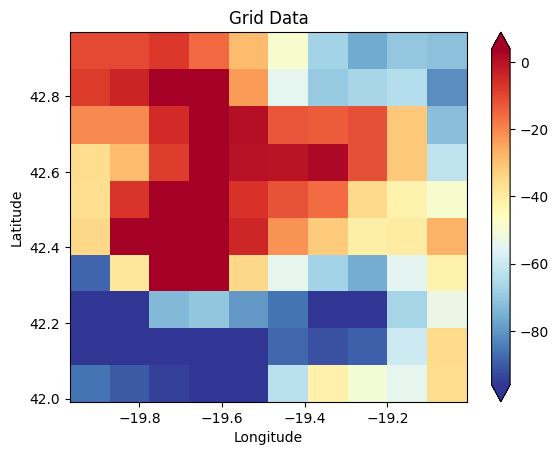

Pandas Apply:   0%|          | 0/321 [00:00<?, ?it/s]

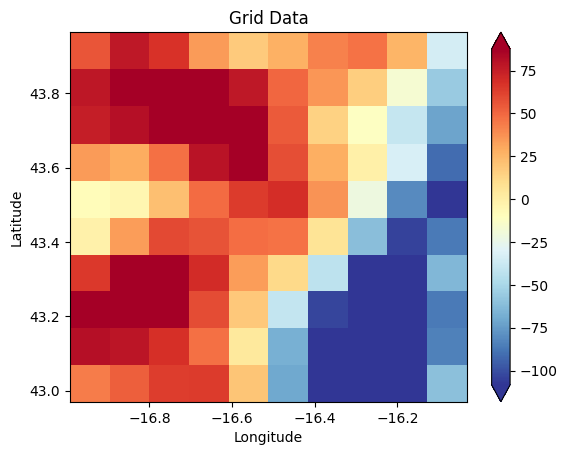

Pandas Apply:   0%|          | 0/10183 [00:00<?, ?it/s]

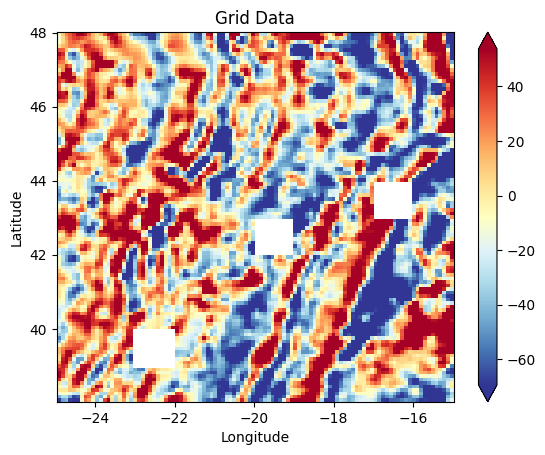

Pandas Apply:   0%|          | 0/321 [00:00<?, ?it/s]

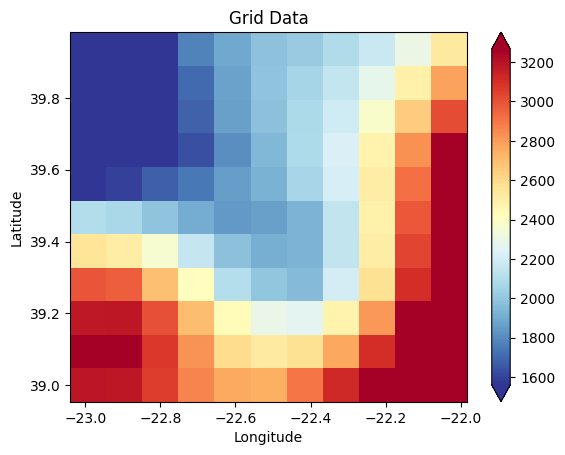

Pandas Apply:   0%|          | 0/321 [00:00<?, ?it/s]

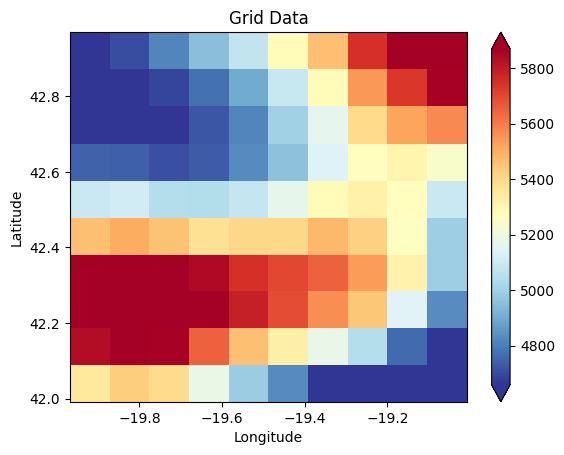

Pandas Apply:   0%|          | 0/321 [00:00<?, ?it/s]

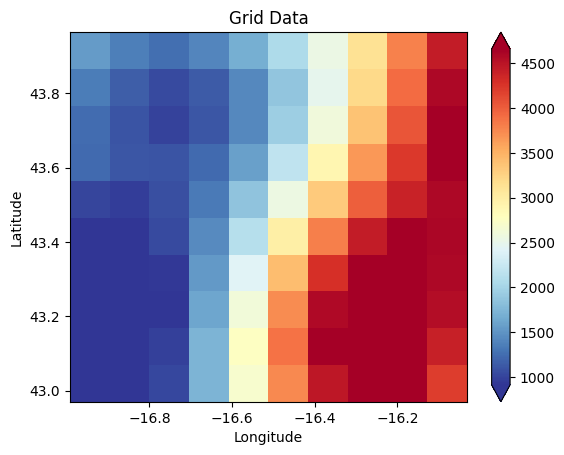

In [6]:
plot_on_selections(holes_grid, holes)
plot_on_selections(big_grid, region)
plot_on_selections(holes_grid, holes,'2_interpolated_emm_')

In [7]:
data = big_grid
data.head()

,Longitude,Latitude,EMAG2v3,3_gl_tot_sed_thick_,14_wgm2012_freeair_ponc_,10_sc_crust_vs_,16_sl_vgg_eot_,12_love_phase_,4_cm_curie_point_depth_,1_interpolated_mf7_,...,6_interpolated_bouguer_,18_igrf_inc_,9__igrf_dec_,15_rayleigh_phase_,5_gl_elevation_,7_sc_crust_vp_,11_love_group_,8_sc_crust_den_,13_rayleigh_group_,17_sc_crust_age_
0,-24.912,38.077288,-74.477388,126.09917,38.459460,3834.3530,37.616886,4.654015,12.870306,12.507781,...,365.297883,54.359588,-12.458831,4.072301,-2646.4824,6749.9595,4.340569,2953.9417,3.667014,39.946033
1,-24.816,38.077288,-46.775229,135.09915,39.343193,3834.4438,41.930910,4.654218,12.695473,11.676283,...,368.865130,54.343718,-12.420341,4.073148,-2617.5203,6751.5884,4.342162,2953.6377,3.668386,40.742508
2,-24.720,38.077288,-41.948499,144.33838,34.544983,3834.4030,34.142776,4.654211,12.488071,10.909296,...,372.551685,54.327923,-12.381830,4.073783,-2811.3240,6751.9893,4.343800,2954.3916,3.669720,41.365948
3,-24.624,38.077288,-67.282752,151.08191,30.625856,3834.6096,29.062958,4.654098,12.210288,10.209252,...,381.637828,54.312204,-12.343299,4.074538,-2945.5999,6752.4110,4.345985,2954.4150,3.671390,41.990875
4,-24.528,38.077288,-95.679948,156.57762,26.337307,3834.7954,25.475803,4.653877,11.882874,9.555889,...,388.467210,54.296559,-12.304748,4.075441,-3111.8904,6752.4253,4.348878,2954.5654,3.673464,42.616740


# Random Forest Regression
A basic random forest model where n estimators, regression trees, are randomly assigned subsets of data and predictors to use as splitting criteria, minimixing variance.

PCA (Principle Component Analysis) was experimented with but was ineffective. This is most likely due to random forest handling collinearity well. Collinearity is how PCA is able to reduce dimensions so intuitively not needed.

Standard training method of a scikit-learn estimator

In [8]:
data.columns


Index(['Longitude', 'Latitude', 'EMAG2v3', '3_gl_tot_sed_thick_',
       '14_wgm2012_freeair_ponc_', '10_sc_crust_vs_', '16_sl_vgg_eot_',
       '12_love_phase_', '4_cm_curie_point_depth_', '1_interpolated_mf7_',
       '2_interpolated_emm_', '6_interpolated_bouguer_', '18_igrf_inc_',
       '9__igrf_dec_', '15_rayleigh_phase_', '5_gl_elevation_',
       '7_sc_crust_vp_', '11_love_group_', '8_sc_crust_den_',
       '13_rayleigh_group_', '17_sc_crust_age_'],
      dtype='object')

## Feature Selection and Clustering

In [9]:
kmeans = KMeans(n_clusters=10, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['Latitude','Longitude']])

# Columns to exclude
exclude_columns = ['EMAG2v3','1_interpolated_mf7_']
include_columns = ['cluster','Longitude','Latitude']



for column in data.columns:
  if column in include_columns or column == 'EMAG2v3' or column in exclude_columns:
    continue
  try:
    if 0 < int(column[0:2]) and int(column[0:2]) <= 10: #select 5 highest ranked
      include_columns.append(column)
  except:
    if 0 < int(column[0]) and int(column[0]) <= 10: #select 5 highest ranked
      include_columns.append(column)
    continue


# Select columns not in exclude_columns using boolean indexing
X = data.loc[:, ~data.columns.isin(exclude_columns)]
X = X.loc[:, X.columns.isin(include_columns)]

X = X.fillna(X.median())

'''
# Normalize the features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
'''

y = data['EMAG2v3']

y = y.fillna(y.median())
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=500, random_state=42,oob_score=True)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)


In [10]:
include_columns

['cluster',
 'Longitude',
 'Latitude',
 '3_gl_tot_sed_thick_',
 '10_sc_crust_vs_',
 '4_cm_curie_point_depth_',
 '2_interpolated_emm_',
 '6_interpolated_bouguer_',
 '9__igrf_dec_',
 '5_gl_elevation_',
 '7_sc_crust_vp_',
 '8_sc_crust_den_']

# Model Evaluation

This section explains the key metrics used to evaluate the performance of a regression model.

In [11]:
evaluate_model(y_test, y_pred,X)

Mean Squared Error: 366.4861180835103
R² Score: 0.8536052147179061
Root Mean Squared Error: 19.143827153511136
Mean Absolute Error: 14.464278765632057
Coefficient of Variation of RMSE: 0.38261571489170937
Included Predictors:
['cluster', 'Longitude', 'Latitude', '3_gl_tot_sed_thick_', '10_sc_crust_vs_', '4_cm_curie_point_depth_', '2_interpolated_emm_', '6_interpolated_bouguer_', '9__igrf_dec_', '5_gl_elevation_', '7_sc_crust_vp_', '8_sc_crust_den_']


## Plotting Comparisons



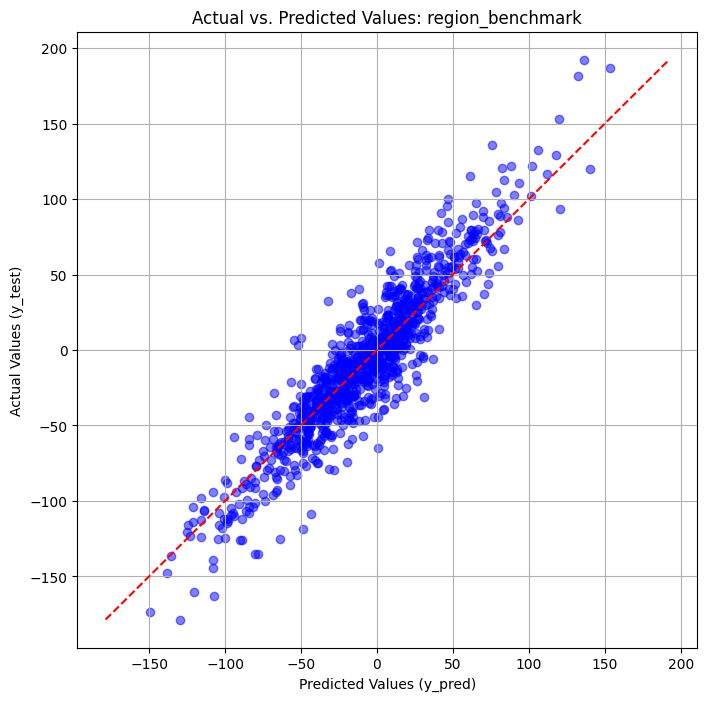

In [12]:
scatter_plot(y_test, y_pred)



---



# Outside/Inside Test Set Evaluation
Previous testing was on values within the trianing region. This section tests the model accuracy on data that is spatially within the training area, but not in the training set.


Results are also plotted against the true values of the training data, which is a less accurate measure of accuracy due to overfitting. The motivation of this plotting is to see how well the model captured spatial data in the region.

In [13]:
import xarray as xr
import matplotlib.pyplot as plt

plot_df = holes_grid
plot_df.head()

,Longitude,Latitude,EMAG2v3,3_gl_tot_sed_thick_,14_wgm2012_freeair_ponc_,10_sc_crust_vs_,16_sl_vgg_eot_,12_love_phase_,4_cm_curie_point_depth_,1_interpolated_mf7_,...,6_interpolated_bouguer_,18_igrf_inc_,9__igrf_dec_,15_rayleigh_phase_,5_gl_elevation_,7_sc_crust_vp_,11_love_group_,8_sc_crust_den_,13_rayleigh_group_,17_sc_crust_age_
0,-22.992,39.000736,-45.552553,130.10468,28.616655,3838.0984,27.276451,4.613408,13.041010,18.830947,...,443.468095,55.137442,-11.801756,4.092034,-3874.2812,6758.1377,4.439398,2955.9110,3.742971,48.510414
1,-22.896,39.000736,-46.655556,125.49996,31.383295,3838.1062,30.315887,4.612854,13.347637,18.981346,...,439.325158,55.123847,-11.762672,4.092809,-3659.7402,6758.1895,4.441663,2955.9438,3.746683,49.035430
2,-22.800,39.000736,-40.893043,121.49998,28.964458,3838.1802,28.833002,4.612415,13.619573,18.703485,...,441.648221,55.110326,-11.723577,4.093573,-3649.2673,6758.2783,4.443928,2955.9773,3.750396,49.560570
3,-22.704,39.000736,-19.550752,118.30235,28.020071,3838.0554,32.064320,4.612122,13.822115,17.975059,...,442.500578,55.096878,-11.684472,4.094331,-3751.5579,6758.0625,4.446199,2955.9000,3.754077,50.085693
4,-22.608,39.000736,6.652089,114.80238,28.426752,3838.8242,31.104784,4.612004,13.977118,16.816300,...,444.248782,55.083503,-11.645358,4.095085,-3726.4850,6759.3916,4.448485,2956.4140,3.757691,50.610737


Mean Squared Error: 976.0179797734351
R² Score: 0.7141128605555672
Root Mean Squared Error: 31.24128646156293
Mean Absolute Error: 24.462292095761867
Coefficient of Variation of RMSE: 0.5346841492361942
Included Predictors:
['cluster', 'Longitude', 'Latitude', '3_gl_tot_sed_thick_', '10_sc_crust_vs_', '4_cm_curie_point_depth_', '2_interpolated_emm_', '6_interpolated_bouguer_', '9__igrf_dec_', '5_gl_elevation_', '7_sc_crust_vp_', '8_sc_crust_den_']


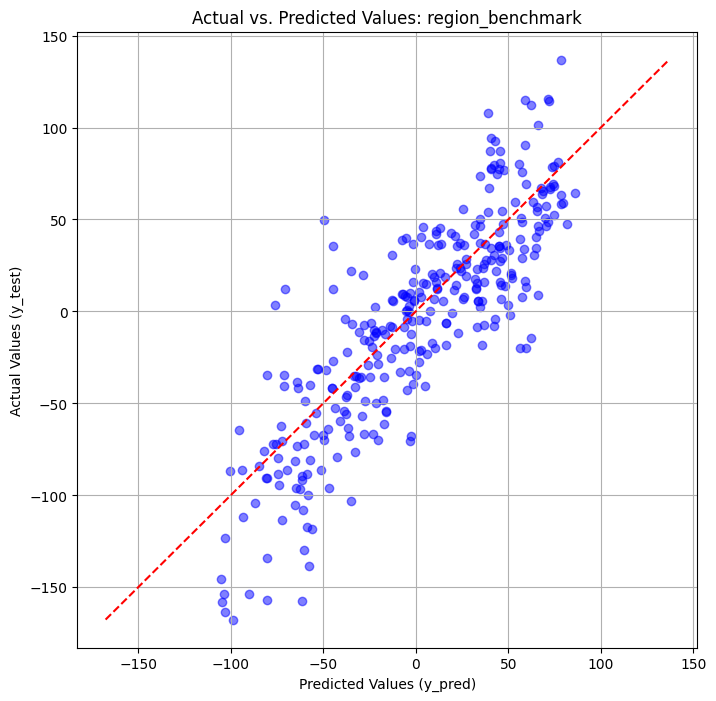

In [14]:


kmeans = KMeans(n_clusters=10, random_state=42)
plot_df['cluster'] = kmeans.fit_predict(plot_df[['Latitude','Longitude']])


# Select columns not in exclude_columns using boolean indexing
X = plot_df.loc[:, ~plot_df.columns.isin(exclude_columns)]
X = X.loc[:, X.columns.isin(include_columns)]


X = X.fillna(X.median())

'''
# Normalize the features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
'''

# Predict on test data
y_pred = rf_model.predict(X)
new_y_test = plot_df['EMAG2v3'].fillna(plot_df['EMAG2v3'].median())
evaluate_model(new_y_test, y_pred,X)

outside_test_df = plot_df[['Longitude', 'Latitude']].copy()
outside_test_df['y_pred'] = y_pred
outside_test_df['y_test'] = new_y_test
scatter_plot(new_y_test, y_pred)

### Graphs Comparing Predicted Data to Actual Data

The plots below display both the model's predicted values (top plot) and the actual recorded values (bottom plot) for the same geographic region.

### Plot Attributes

- **Axes**: Longitude (x-axis) and Latitude (y-axis).
- **Color Scale**: Represents the magnitude of values.
  - **Predicted Data**: Ranges from approximately -300 to 100.
  - **Actual Data**: Ranges from approximately -400 to 400.
- **Colors**:
  - **Red**: Indicates higher values.
  - **Blue**: Indicates lower values.

### Analysis

- **Comparison**: Visually compare the spatial patterns and color distributions.
- **Ideal Outcome**: Predicted data should closely resemble actual data.
- **Discrepancies**: Highlight areas where the model's predictions differ from actual values, indicating the need for model adjustments or additional features.

These plots provide a quick visual assessment of the model's accuracy and highlight areas for potential improvement.

In [15]:
# Pivot the DataFrame
def dataframe_to_grid_plot_metric_list(df):
  for hole in holes:
    print(hole)
    outside_test_df = filter_by_boundary_boxes(df, hole)
    outside_test_df = outside_test_df.reset_index(drop=True)
    for result in ['y_pred','y_test']:

      pivot_df = outside_test_df.pivot(index='Latitude', columns='Longitude', values= result)

      data_array = xr.DataArray(pivot_df.values, coords=[pivot_df.index, pivot_df.columns],
                                            dims=['Latitude', 'Longitude'])
      data_array.plot(vmin = np.percentile(y_train,10), vmax = np.percentile(y_train,90), cmap='RdYlBu_r')
      plt.title(f'{result} values')
      plt.xlabel('Longitude')
      plt.ylabel('Latitude')
      plt.show()
      print('\n\n')



(39, -23, 40, -22)


Pandas Apply:   0%|          | 0/321 [00:00<?, ?it/s]

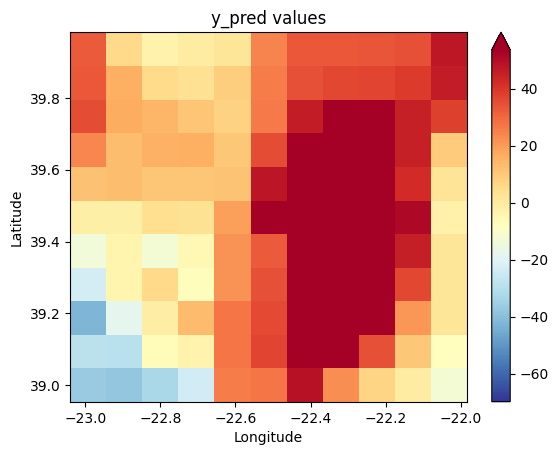

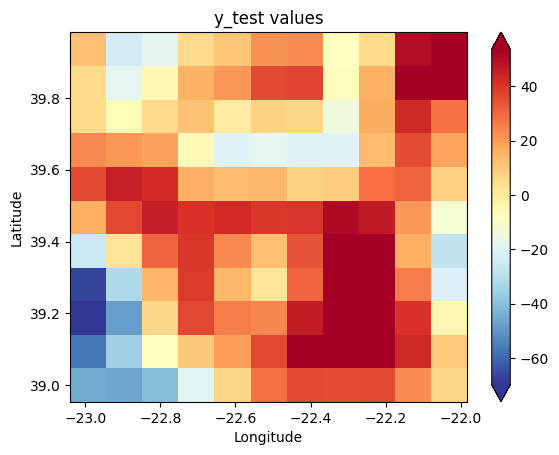




(42, -20, 43, -19)


Pandas Apply:   0%|          | 0/321 [00:00<?, ?it/s]

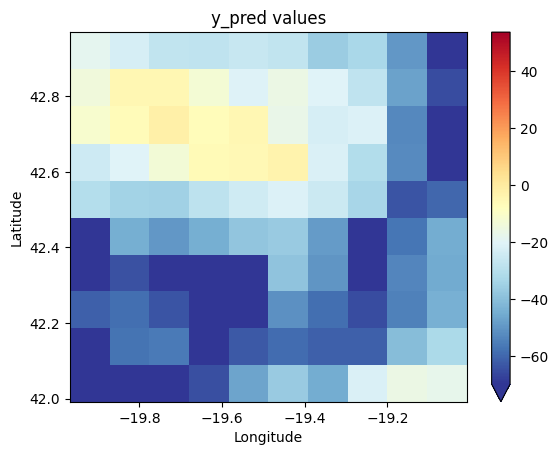

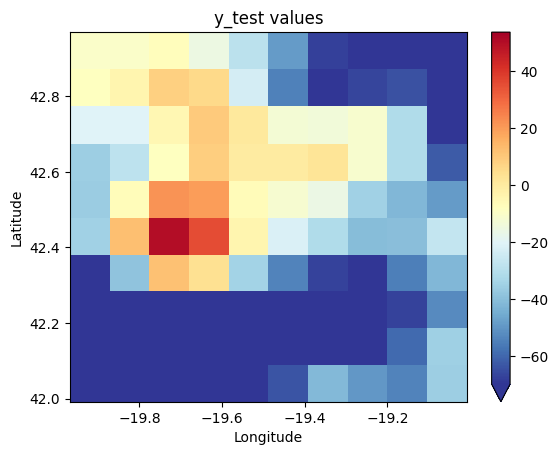




(43, -17, 44, -16)


Pandas Apply:   0%|          | 0/321 [00:00<?, ?it/s]

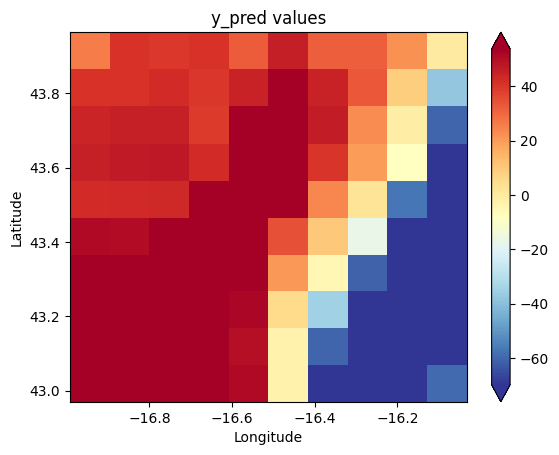

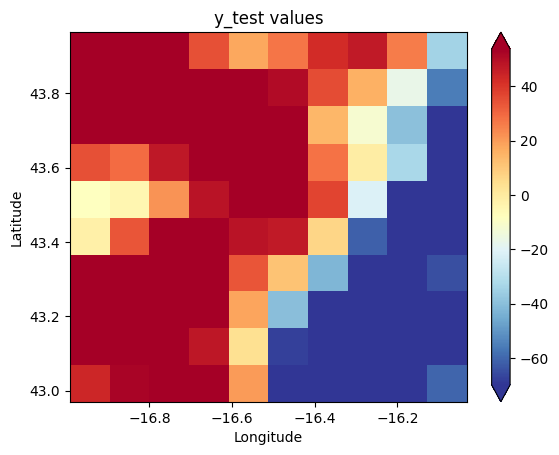

In [16]:
dataframe_to_grid_plot_metric_list(outside_test_df)

# Feature Importances


Feature ranking:
Feature: 4_cm_curie_point_depth_, Importance: 0.3979
Feature: 6_interpolated_bouguer_, Importance: 0.1763
Feature: 10_sc_crust_vs_, Importance: 0.0687
Feature: Longitude, Importance: 0.0532
Feature: Latitude, Importance: 0.0522
Feature: cluster, Importance: 0.0496
Feature: 2_interpolated_emm_, Importance: 0.0431
Feature: 3_gl_tot_sed_thick_, Importance: 0.0430
Feature: 9__igrf_dec_, Importance: 0.0420
Feature: 7_sc_crust_vp_, Importance: 0.0315
Feature: 5_gl_elevation_, Importance: 0.0299
Feature: 8_sc_crust_den_, Importance: 0.0125


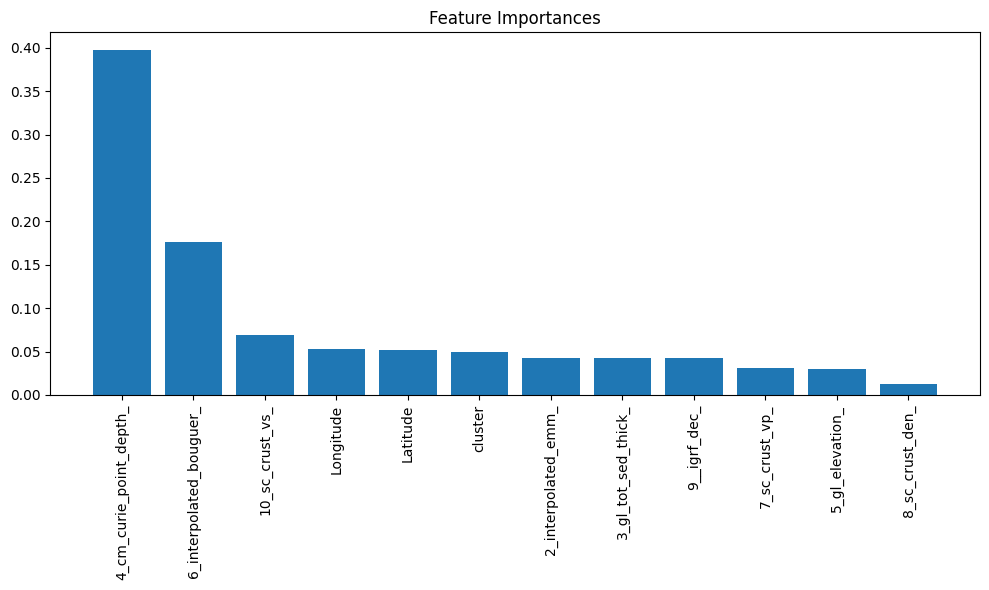

In [17]:
# Step 3: Extract and plot the feature importances
importances = rf_model.feature_importances_  # Extract feature importances
indices = np.argsort(importances)[::-1]      # Sort in descending order

# Print the feature ranking with names
print("Feature ranking:")
for i in indices:
    print(f"Feature: {include_columns[i]}, Importance: {importances[i]:.4f}")


# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [include_columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

In [18]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)


In [19]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{include_columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

4_cm_curie_point_depth_2.353 +/- 0.071
6_interpolated_bouguer_0.582 +/- 0.027
10_sc_crust_vs_0.111 +/- 0.007
Longitude0.107 +/- 0.008
cluster 0.096 +/- 0.006
Latitude0.062 +/- 0.004
3_gl_tot_sed_thick_0.060 +/- 0.005
2_interpolated_emm_0.051 +/- 0.005
9__igrf_dec_0.044 +/- 0.004
5_gl_elevation_0.032 +/- 0.003
7_sc_crust_vp_0.031 +/- 0.003
8_sc_crust_den_0.022 +/- 0.003
